## Long Short Term Memory Networks for Anomaly Detection in Time Series : analisi e implementazione
Questa sezione implementa e analizza "Malhotra, Pankaj & Vig, Lovekesh & Shroff, Gautam & Agarwal, Puneet. (2015). Long Short Term Memory Networks for Anomaly Detection in Time Series.". Questo lavoro propone di usare una LSTM addestrata per prevedere l'andamento della stessa serie temporale spostata in avanti di un giorno (ponendo come input la sequenza dei 14 giorni precedenti) e di usare la differenza tra la sequenza prevista e quella reale per ottenere un vettore degli errori (vettore dei residui). I vettori dei residui vengono poi usati per calcolare la media e la covarianza per stimare la distribuzione gaussiana multivariata dei dati non anomali. In seguito, viene trovata una soglia per separare i dati anomali da quelli normali massimizzando $F_{0.1}$. Inoltre, diversamente da quanto proposto, se invece di usare la likelihood della distribuzione si usa la norma $L^{p}$ del vettore dei residui è possibile ottenere risultati mediamente migliori. <br>
Il dataset è stato separato nel seguente modo:
* Training: Usato per addestrare la rete neurale (contiene solo dati non anomali)
* Test: Usato per valutare il risultato finale (contiene sia dati anomali che normali)
* Validation 1: Usato per early stop e stima di media e varianza (contiene solo dati non anomali)
* Validation 2: Usato per trovare la soglia ottimale (contiene sia dati anomali che normali)

In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import tensorflow.keras.layers as layers
from sklearn.model_selection import KFold
import scipy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval, rand
import seaborn as sns
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.preprocessing import QuantileTransformer, quantile_transform, PowerTransformer, power_transform, robust_scale, minmax_scale
from pingouin import multivariate_normality
import gc

### Parametri
In questa sezione definiamo i parametri e le costanti utilizzate.

In [2]:
DAY = 12 # numero di punti per giorno
BATCH_SIZE = 512 # dimensione batch
WINDOW_OFFSET = DAY * 1 # distanza tra x[0] e y[0]
WINDOW_SIZE = DAY * 14 # dimensione della finestra utilizzata
WINDOW_SEEN = DAY * 7 # vengono considerati solo risultati da y[WINDOW_SEEN:]
FIG_SIZE = (16, 10) # dimensione grafici
HYPERTUNE = False # per la ricerca degli iperparametri

### Funzioni Utili

In [3]:
def get_windows(x, win_in=WINDOW_SIZE, win_off=WINDOW_OFFSET, skip=8):
    # Converte una serie di dati in un serie di finestre sovrapposte di dimensione win_in
    x = x[::skip]
    y = np.vstack([x[i+win_off:i+win_in+win_off] for i in range(len(x)-win_in-win_off)])
    x = np.vstack([x[i:i+win_in] for i in range(len(x)-win_in-win_off)])
    x = np.expand_dims(x, axis=-1)
    y = np.expand_dims(y, axis=-1)
    return x, y

In [4]:
def get_model(units=[40, 30], dropout_rate=0.1, inp_noise=0.0, inp_dropout=0.0, loss='mse', recurrent='lstm', lr=1e-2, dense_activation='sigmoid', hidden_unit=1, ensemble=1):
    # Genera un modello in base agli iperparametri passati
    
    inp = layers.Input(shape=(None, 1))
    x = inp
    base = x
    
    if recurrent != 'none':
        recurrent_layer = {
            'gru': layers.GRU,
            'lstm': layers.LSTM,
            'rnn': layers.SimpleRNN,
        }[recurrent]
        ans = 0
        x = base
        for i in range(ensemble):
            x = tf.keras.layers.GaussianNoise(inp_noise)(x)
            x = tf.keras.layers.Dropout(inp_dropout)(x)

            for unit in units:
                x = recurrent_layer(unit, return_sequences=True)(x)
                x = layers.Dropout(dropout_rate)(x)
                if dense_activation != 'zero':
                    x = layers.Dense(unit)(x)
                    x = layers.Activation(dense_activation)(x)


            x = layers.Dense(1)(x)
            ans += x
        ans /= ensemble
        x = ans
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(lr)
    loss = {'mse':'mse',
         'mae':'mae',
         'mape': 'mape',
         'robust':tfa.losses.pinball_loss
    }[loss]
    model.compile(opt, loss, metrics=['mse', 'mape', 'mae'])
    return model


In [5]:
def run(x, holidays, params={}, verbose=1, batch_size=BATCH_SIZE, maxpos=WINDOW_SEEN):
    # addestra il modello sui dati in input (x e holidays) e resistituisce i risultati e le metriche ottenute in un dizionario
    # i parametri params vengono usati per generare il modello (tramite get_model)
    if 'rob_cov' in params:
        rob_cov = params['rob_cov']
        del params['rob_cov']
    else:
        rob_cov = False
        
    x = np.clip(x, np.percentile(x, 5), np.percentile(x, 95))
    x = minmax_scale(x.reshape(-1, 1)).flatten()
    
    print(len(holidays[holidays == 0]), len(holidays[holidays == 1]))
    
    x, y = get_windows(x)
    x_cnt = np.arange(len(x))
    x_holidays, y_holidays = get_windows(holidays)
    x_holidays = np.squeeze(x_holidays)
    y_holidays = np.squeeze(y_holidays)
    
    # split sets
    cond = ((x_holidays == 1).any(-1))|((y_holidays == 1).any(-1))
    x_anom = x[cond]
    x_noanom = x[~cond]
    y_anom = y[cond]
    y_noanom = y[~cond]
    cnt_anom = x_cnt[cond]
    cnt_noanom = x_cnt[~cond]
    
    good_split = [0.45, 0.625, 0.75]
    anomaly_split = [0.45]
    good_int = [int(len(x_noanom)*a) for a in good_split]
    anomaly_int = [int(len(x_anom)*a) for a in anomaly_split]
    x_train, x_val1, x_val2, x_test = np.split(x_noanom, good_int)
    y_train, y_val1, y_val2, y_test = np.split(y_noanom, good_int)
    cnt_train, cnt_val1, cnt_val2, cnt_test = np.split(cnt_noanom, good_int)

    x_aval2, x_atest = np.split(x_anom, anomaly_int)
    y_aval2, y_atest = np.split(y_anom, anomaly_int)
    cnt_aval2, cnt_atest = np.split(cnt_anom, anomaly_int)

    x_val2 = np.concatenate([x_val2, x_aval2])
    y_val2 = np.concatenate([y_val2, y_aval2])
    cnt_val2 = np.concatenate([cnt_val2, cnt_aval2])

    x_test = np.concatenate([x_test, x_atest])
    y_test = np.concatenate([y_test, y_atest])
    cnt_test = np.concatenate([cnt_test, cnt_atest])
    
    print('x_train:', x_train.shape)
    print('x_val1:', x_val1.shape)
    print('x_val2:', x_val2.shape)
    print('x_test:', x_test.shape)
    
    # fit
    model = get_model(**params)
    hist = model.fit(x_train, y_train,
             batch_size=batch_size,
             epochs=1000,
             verbose = verbose,
             validation_data=(x_val1, y_val1),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, verbose=True)
    ]).history
    
    # postprocess
    def gen_ans(x_curr, y_curr, cnt_curr):
        ans = [[] for i in range(len(x) + 2*WINDOW_SIZE)]
        ans_pred = [[] for i in range(len(x) + 2*WINDOW_SIZE)]
        ans_curr = [[] for i in range(len(x) + 2*WINDOW_SIZE)]
        y_pred = model.predict(x_curr)
        
        for off, win_pred, win_curr in zip(cnt_curr, y_pred, y_curr):
            for p0, (val_pred, val_curr) in enumerate(zip(win_pred, win_curr)):
                ans[off + p0].append(val_pred[0] - val_curr[0])
                ans_pred[off + p0].append(val_pred[0])
                ans_curr[off + p0].append(val_curr[0])
        
        pos = [i for i in range(len(ans)) if len(ans[i]) >= maxpos]
        ans = [v[:maxpos] for v in ans if len(v) >= maxpos]
        ans_pred = [v[:maxpos] for v in ans_pred if len(v) >= maxpos]
        ans_curr = [v[:maxpos] for v in ans_curr if len(v) >= maxpos]
        
        return np.array(pos), np.array(ans), np.array(ans_pred), np.array(ans_curr)

    pos_train, ans_train, pred_train, curr_train = gen_ans(x_train, y_train, cnt_train)
    pos_val1, ans_val1, pred_val1, curr_val1 = gen_ans(x_val1, y_val1, cnt_val1)
    pos_val2, ans_val2, pred_val2, curr_val2 = gen_ans(x_val2, y_val2, cnt_val2)
    pos_test, ans_test, pred_test, curr_test = gen_ans(x_test, y_test, cnt_test)
    
    
    assert len(holidays) // 8 > pos_test.max() + WINDOW_OFFSET, f'{len(holidays) // 8} < {pos_test.max() + WINDOW_OFFSET}'
    assert pos_test.min() >= 0, f'{pos_test.min()} < 0'
    assert len(holidays) // 8 > pos_val2.max() + WINDOW_OFFSET, f'{len(holidays) // 8} < {pos_val2.max() + WINDOW_OFFSET}'
    assert pos_test.min() >= 0, f'{pos_val2.min()} < 0'
    
    holi_test = holidays[::8][pos_test + WINDOW_OFFSET]
    holi_val2 = holidays[::8][pos_val2 + WINDOW_OFFSET]
    
    assert holidays[::8][pos_train + WINDOW_OFFSET].sum() == 0
    assert holidays[::8][pos_val1  + WINDOW_OFFSET].sum() == 0
    assert holi_test.sum() > 0
    assert holi_val2.sum() > 0
    
    print('holi_test:', holi_test.sum())
    print('holi_val2:', holi_test.sum())
    
    if rob_cov:
        mcd = MinCovDet(support_fraction=0.8).fit(ans_val1)
    else:
        mcd = EmpiricalCovariance().fit(ans_val1)
    
    mean = mcd.location_
    cov = mcd.covariance_
    
    ans = {}
    for h in hist:
        ans[h] = min(hist[h])
    ans['mean'] = mean
    ans['cov'] = cov
    ans['res_train'] = ans_train
    ans['res_test'] = ans_test
    ans['res_val1'] = ans_val1
    ans['res_val2'] = ans_val2
    ans['holidays_val2'] = holi_val2
    ans['holidays_test'] = holi_test
    ans['y_train_pred'] = pred_train
    ans['y_test_pred'] = pred_test
    ans['y_val1_pred'] = pred_val1
    ans['y_val2_pred'] = pred_val2
    ans['y_train'] = curr_train
    ans['y_test'] = curr_test
    ans['y_val1'] = curr_val1
    ans['y_val2'] = curr_val2
    ans['cnt_train'] = pos_train
    ans['cnt_test'] = pos_test
    ans['cnt_val1'] = pos_val1
    ans['cnt_val2'] = pos_val2

    return ans

In [6]:
def conv2week(cnts, y_true, y_pred):
    # unisce le previsioni per settimane
    f_valid = False
    for dx in range(7):
        conta = np.zeros(max(cnts))
        holi_score = np.zeros(max(cnts))
        pred_score = np.zeros(max(cnts))
        for cnt, val, p in zip(cnts, y_true, y_pred):
            cnt = (cnt + dx) // 7
            conta[cnt] += 1
            holi_score[cnt] += val
            pred_score[cnt] += p
        week_used = conta > 1
        holi_score = holi_score[week_used] / conta[week_used]
        pred_score = pred_score[week_used] / conta[week_used]
        if len(holi_score[(holi_score>1e-9)&(holi_score<1-1e-9)]) == 0:
            f_valid = True
        if f_valid:
            break
            
    return (holi_score > 0.5).astype('int8'), pred_score, (pred_score > 0).astype('int8')


def print_results(ans, use_val=True, print_resp=True, distance_metric=2):
    # Questa funziona prima converte ogni vettori dei residui in un valore reale (usando la likelihood o la norma $L^{p}$). 
    # Successivamente stima il valore threshold tra istanti anomali e non anomali, ovvero il valore che massimizzi la metrica $F_{0.1}$ usando il validation 2. 
    # In seguito, valuta la soglia scelta rispetto al test set.
    if use_val:
        res_thresh = ans['res_val2']
        holidays_thresh = ans['holidays_val2']        
        cnt_thresh = ans['cnt_val2']
    else:
        res_thresh = ans['res_test']
        holidays_thresh = ans['holidays_test']
        cnt_thresh = ans['cnt_test']
    
    if distance_metric == 'prob':
        prob = scipy.stats.multivariate_normal.pdf(res_thresh, mean=ans['mean'], cov=ans['cov'], allow_singular=True)
        prob[~np.isfinite(prob)] = 1e300
    else:
        prob = np.linalg.norm(res_thresh, axis=1, ord=distance_metric)
    
    threshold = 0
    threshold_i = -1
    bestf0_1 = 0
    prob_sorted = np.sort(prob.copy())
    best_conf_matrix = -1
    step = len(prob_sorted)
    for i in range(step):
        p = prob_sorted[i]
        y_pred = (prob > p).astype('int8')
        if distance_metric == 'prob':
            y_pred = 1 - y_pred
        y_true, y_prob, y_pred = conv2week(cnt_thresh, holidays_thresh, y_pred)
        f0_1 = metrics.fbeta_score(y_true, y_pred, beta=0.1)
        if bestf0_1 < f0_1:
            bestf0_1 = f0_1
            threshold = p
            threshold_i = i
    
    if distance_metric == 'prob':
        prob = scipy.stats.multivariate_normal.pdf(ans['res_test'], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
        prob[~np.isfinite(prob)] = 1e300
    else:
        prob = np.linalg.norm(ans['res_test'], axis=1, ord=distance_metric)
    y_pred = (prob > threshold).astype('int8')
    if distance_metric == 'prob':
        y_pred = 1 - y_pred
    
    y_true, y_prob, y_pred = conv2week(ans['cnt_test'], ans['holidays_test'], y_pred)
    
    f0_1 = metrics.fbeta_score(y_true, y_pred, beta=0.1)
    acc = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    auc = metrics.roc_auc_score(y_true, y_pred)

    cm = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred))

    cm.index.name = 'Reale'
    cm.columns.name = 'Previsto'
    resp = {}
    resp['auc'] = auc
    resp['f0.1'] = f0_1
    resp['accuracy'] = acc
    resp['recall'] = recall
    resp['precision'] = precision
    resp['threshold'] = threshold
    resp['cm'] = cm

    if print_resp:
        print(f'threshold: {threshold} ({threshold_i}/{len(prob_sorted)}) - f0.1: {f0_1} - f0.1(validation): {bestf0_1}')
        print({name:resp[name] for name in resp if name not in ['threshold', 'f0.1', 'cm']})
        print()
        print(metrics.classification_report(y_true, y_pred))
        fig, axs = plt.subplots(figsize=(16, 8), ncols=2)

        sns.heatmap(cm, cmap="Blues", annot=True,annot_kws={"size": 16}, ax=axs[0])
        prec, recall, _ = metrics.precision_recall_curve(y_true, y_prob)
        pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=axs[1])
        plt.show()

    if not print_resp:
        return resp

In [7]:
def parse_params(params):
    # converte gli iperparametri in parametri per get_model
    params['units'] = []
    params['ensemble'] = int(params['ensemble'])
    for i in range(3):
        if i < params['n_layers']:
            params['units'].append(int(params[f'unit_{i}']))
        del params[f'unit_{i}']
    del params['n_layers']
    del params['batch_size']
    del params['distance_metric']
    del params['maxpos']
    return params

df_x, df_y = [], []
def objective(params):
    # funzione obiettivo per fmin
    global df_y, df_x
    real_params = params.copy()
    
    batch_size = int(2**params['batch_size'])
    distance_metric = params['distance_metric']
    maxpos = int(params['maxpos'])
    
    params = parse_params(params)
    ans0 = run(df_x, df_y, params=params, batch_size=batch_size, verbose=0, maxpos=maxpos)
    ans0 = print_results(ans0, print_resp=False, distance_metric=distance_metric)
    if ans0['f0.1'] > 0.3:
        ans1 = run(df_x, df_y, params=params, batch_size=batch_size, verbose=0, maxpos=maxpos)
        ans1 = print_results(ans1, print_resp=False, distance_metric=distance_metric)
    else:
        ans1 = ans0.copy()
    score = -ans0['f0.1']-ans1['f0.1']
    
    print(real_params, params)
    print(score, ans0, ans1)
    
    return score

space = {'n_layers':hp.quniform('n_layers', 1, 3, 1),
         'unit_0':hp.quniform('unit_0', 32, 256, 1),
         'unit_1':hp.quniform('unit_1', 32, 128, 1),
         'unit_2':hp.quniform('unit_2', 4, 128, 1),
         'batch_size':hp.uniform('batch_size', 7, 7.1),
         'dropout_rate':hp.uniform('dropout_rate', 0.0, 0.7), 
         'hidden_unit': hp.quniform('hidden_unit', 64, 256, 1),
         'inp_noise':hp.uniform('inp_noise', 0.0, 0.7),
         'inp_dropout':hp.uniform('inp_dropout', 0.0, 0.7),
         'ensemble': hp.quniform('ensemble', 1, 5, 1),
         'dense_activation': hp.choice('dense_activation', ['swish']),
         'loss':hp.choice('loss', ['mse']),
         'recurrent':hp.choice('recurrent', ['lstm']),
         'distance_metric': hp.choice('distance_metric', [2]),
         'maxpos': hp.quniform('maxpos', WINDOW_SIZE - 2 * DAY, WINDOW_SIZE - 1 * DAY, 1),
}

### Paesi Bassi
Il dataset è molto omogeneo e regolare. Quindi risulta più semplice per il modello prevedere lo schema settimanale. Lo stesso dataset è stato usato anche dagli autori del paper (sotto il nome di Power demand dataset). I risultati ottenuti sono molti simili anche se i modelli utilizzati sono leggermente diversi (in particolare nella scelta degli ottimizzatori e nel numero di parametri).

In [8]:
df = pd.read_pickle('train2.pkl').astype('int32')
df

,x,holidays
0,950,1
1,939,1
2,943,1
3,971,1
4,1014,1
...,...,...
35035,622,1
35036,614,1
35037,627,1
35038,633,1


Gli iperparametri usati sono stati trovati usando TPE (Tree of Parzen Estimators). <br>
Il modello è composto da stacked LSTM e tra ogni livello di LSTM è presente un fully connected layer seguito da una funzione di attivazione (swish).

In [9]:
if HYPERTUNE:
    df_x, df_y = df['x'].to_numpy(), df['holidays'].to_numpy()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=40)
else:
    best = None
gc.collect()
best

In [10]:
params = {'dense_activation': 'swish', 
          'dropout_rate': 0.2, 
          'ensemble': 5, 
          'hidden_unit': 160, 
          'inp_dropout': 0.3, 
          'inp_noise': 0.0, 
          'loss': 'mse', 
          'recurrent': 'lstm', 
          'units': [50]
}


In [11]:
ans = run(df['x'].to_numpy(), df['holidays'].to_numpy(), params=params)

30336 4704
x_train: (1421, 168, 1)
x_val1: (553, 168, 1)
x_val2: (863, 168, 1)
x_test: (1363, 168, 1)
Epoch 1/1000
3/3 [==============================] - 3s 865ms/step - loss: 0.1615 - mse: 0.1615 - mape: 8010204.0000 - mae: 0.2861 - val_loss: 0.6420 - val_mse: 0.6420 - val_mape: 7356744.5000 - val_mae: 0.7427
Epoch 2/1000
3/3 [==============================] - 0s 148ms/step - loss: 0.2975 - mse: 0.2975 - mape: 38526648.0000 - mae: 0.4339 - val_loss: 0.0936 - val_mse: 0.0936 - val_mape: 1130846.6250 - val_mae: 0.2048
Epoch 3/1000
3/3 [==============================] - 0s 143ms/step - loss: 0.1279 - mse: 0.1279 - mape: 10233621.0000 - mae: 0.2402 - val_loss: 0.0907 - val_mse: 0.0907 - val_mape: 1225127.8750 - val_mae: 0.2043
Epoch 4/1000
3/3 [==============================] - 0s 143ms/step - loss: 0.1122 - mse: 0.1122 - mape: 17176518.0000 - mae: 0.2533 - val_loss: 0.0728 - val_mse: 0.0728 - val_mape: 2419219.2500 - val_mae: 0.2382
Epoch 5/1000
3/3 [==============================] - 0s 

Epoch 39/1000
3/3 [==============================] - 0s 143ms/step - loss: 0.0296 - mse: 0.0296 - mape: 9100073.0000 - mae: 0.1201 - val_loss: 0.0157 - val_mse: 0.0157 - val_mape: 729344.5625 - val_mae: 0.0885
Epoch 40/1000
3/3 [==============================] - 0s 140ms/step - loss: 0.0290 - mse: 0.0290 - mape: 8706960.0000 - mae: 0.1187 - val_loss: 0.0172 - val_mse: 0.0172 - val_mape: 674175.7500 - val_mae: 0.0948
Epoch 41/1000
3/3 [==============================] - 0s 140ms/step - loss: 0.0286 - mse: 0.0286 - mape: 8212164.0000 - mae: 0.1175 - val_loss: 0.0164 - val_mse: 0.0164 - val_mape: 666284.8750 - val_mae: 0.0918
Epoch 42/1000
3/3 [==============================] - 0s 140ms/step - loss: 0.0280 - mse: 0.0280 - mape: 8061248.5000 - mae: 0.1161 - val_loss: 0.0162 - val_mse: 0.0162 - val_mape: 632821.3125 - val_mae: 0.0912
Epoch 43/1000
3/3 [==============================] - 0s 139ms/step - loss: 0.0277 - mse: 0.0277 - mape: 8180834.5000 - mae: 0.1154 - val_loss: 0.0169 - val_mse:

In [12]:
for metric, val_metric in [('mse', 'val_mse'), ('mae', 'val_mae'), ('mape', 'val_mape')]:
    print(f"{metric.rjust(8)}: {str(round(ans[metric], 3)).rjust(8)} - {str(round(ans[val_metric], 3)).rjust(8)}")

     mse:    0.025 -    0.016
     mae:    0.108 -    0.088
    mape: 7432699.5 - 560885.25


#### Analisi della distribuzione del residuo
In questa sezione, si verifica se la distribuzione del residuo (la differenza tra il valore reale e il valore predetto) sia gaussiana.<br>
Possiamo osservare che tutti i test statistici effettuati (Henze-Zirkler, Kolmogorov-Smirnov, D’Agostino-Pearson) concludono che la distribuzione dei residui non sia gaussiana (p-value minore di $10^{-10}$).

In [13]:
# normality test
def avg_pval(x):
    v = [multivariate_normality(np.random.default_rng().choice(x, size=10, axis=0)[:,:20], alpha=.05).pval for _ in range(200)]
    v = [i for i in v if not np.isnan(i)]
    return np.mean(v)

# Henze-Zirkler test
print('ans_train:', multivariate_normality(ans['res_train'][:,:20], alpha=0.5), avg_pval(ans['res_train']))
print('ans_val1:', multivariate_normality(ans['res_val1'][:,:20], alpha=0.5), avg_pval(ans['res_val1']))
print('ans_val2:', multivariate_normality(ans['res_val2'][:,:20], alpha=0.5), avg_pval(ans['res_val2']))
print('ans_test:', multivariate_normality(ans['res_test'][:,:20], alpha=0.5), avg_pval(ans['res_test']))
print()

args = (ans['mean'], ans['cov'], True, int(5e4))
# Kolmogorov-Smirnov test
print('ans_train:', scipy.stats.kstest(np.random.default_rng().choice(ans['res_train'], size=150, axis=0), scipy.stats.multivariate_normal.cdf, N=10, args=args))
print('ans_val1:', scipy.stats.kstest(np.random.default_rng().choice(ans['res_val1'], size=150, axis=0), scipy.stats.multivariate_normal.cdf, N=10, args=args))
print('ans_val2:', scipy.stats.kstest(np.random.default_rng().choice(ans['res_val2'], size=150, axis=0), scipy.stats.multivariate_normal.cdf, N=10, args=args))
print('ans_test:', scipy.stats.kstest(np.random.default_rng().choice(ans['res_test'], size=150, axis=0), scipy.stats.multivariate_normal.cdf, N=10, args=args)) 

ans_train: HZResults(hz=104.03377428068991, pval=0.0, normal=False) 0.0
ans_val1: HZResults(hz=34.56575032249778, pval=0.0, normal=False) 0.0
ans_val2: HZResults(hz=77.28464479936606, pval=0.0, normal=False) 0.0
ans_test: HZResults(hz=147.04987178910466, pval=0.0, normal=False) 0.0

ans_train: KstestResult(statistic=0.9825721325742006, pvalue=3.073740035480907e-264)
ans_val1: KstestResult(statistic=0.9399999785979606, pvalue=1.0562462374692051e-183)
ans_val2: KstestResult(statistic=0.9581389597483491, pvalue=3.73708060475092e-207)
ans_test: KstestResult(statistic=0.9466666666666665, pvalue=2.2430648519286604e-191)


In [14]:
# p-value ottenuto con D’Agostino-Pearson test (test effettuato per ogni dimensione)
for idx, (res_train, res_test) in enumerate(zip(ans['res_train'].T, ans['res_test'].T)):
    print(f'{idx} - training set: {scipy.stats.normaltest(res_train).pvalue} test set: {scipy.stats.normaltest(res_test).pvalue}')


0 - training set: 4.4089296351183227e-10 test set: 9.490173404460221e-133
1 - training set: 4.069184877340114e-10 test set: 1.1372887791377146e-132
2 - training set: 3.839516785991348e-10 test set: 4.884389432845841e-133
3 - training set: 3.895534762883503e-10 test set: 9.070117644861156e-134
4 - training set: 4.3500399033640716e-10 test set: 2.8073737670830746e-134
5 - training set: 4.852385210962557e-10 test set: 4.1006134118898046e-134
6 - training set: 4.1377142412020196e-10 test set: 9.803754731103993e-134
7 - training set: 3.707517056810645e-10 test set: 1.765126545897048e-133
8 - training set: 4.3441972111691947e-10 test set: 1.4314307014224424e-133
9 - training set: 7.226883278020698e-10 test set: 2.1694171699834697e-134
10 - training set: 7.16653276945752e-10 test set: 2.8259020560600365e-135
11 - training set: 6.470398759025151e-10 test set: 5.379455797389291e-135
12 - training set: 5.56622535370121e-10 test set: 4.690619789638218e-133
13 - training set: 5.994853718071379e-10

#### Istogramma dei residui per istante
Nelle celle successive possiamo osservare come si comporta il residuo in diversi istanti di tempo e set. <br>
In particolare, possiamo osservare che i dataset con anomalie (val2 e test) abbiano una distribuzione con code molto più lunghe rispetto ai dataset senza anomalie (val1 e training)

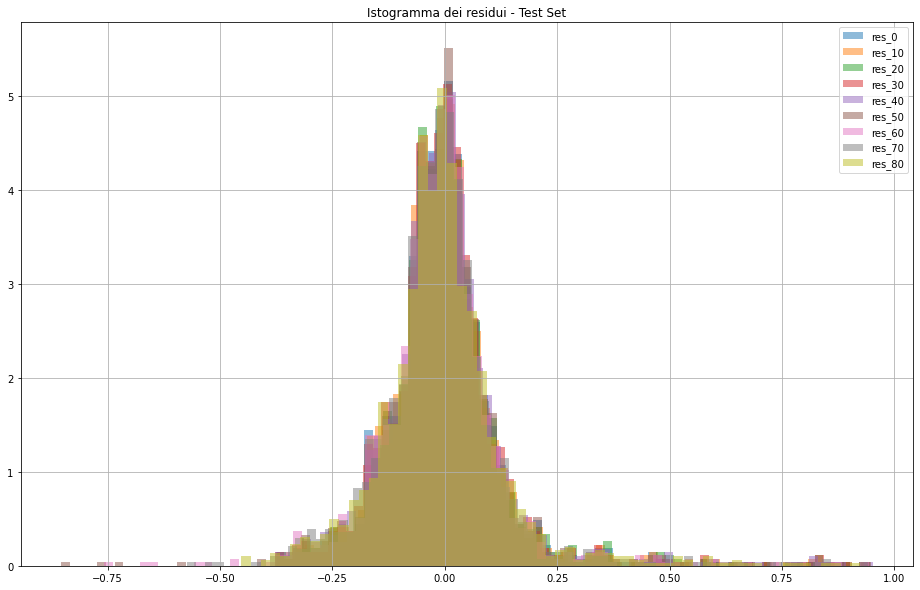

In [15]:
#res plot val1
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
for i in range(0, ans['res_test'].shape[-1], 10):
    ax.hist([b[i] for b in ans['res_test']], label=f'res_{i}', bins='auto', density=True, alpha=0.5)
ax.set_title('Istogramma dei residui - Test Set')
ax.grid()
ax.legend()
plt.show()

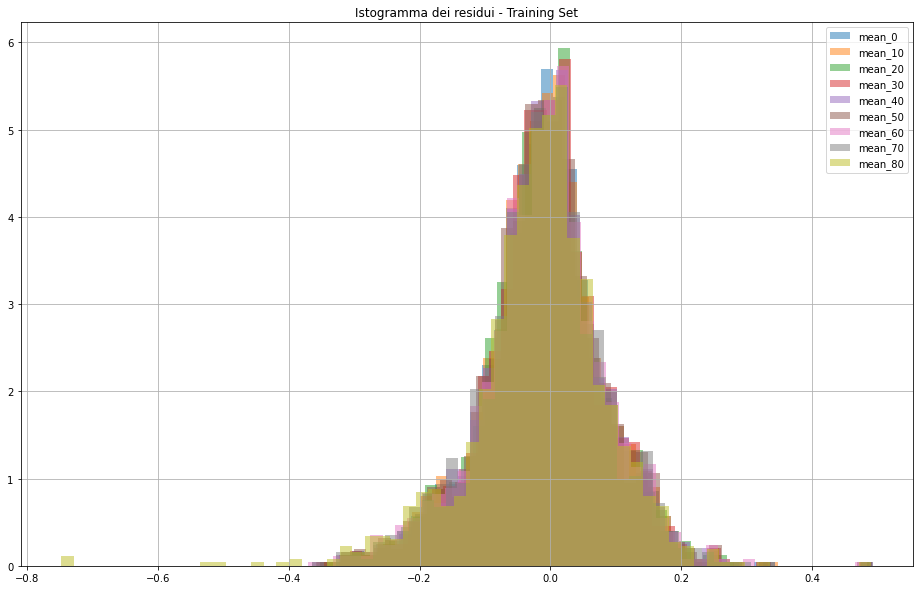

In [16]:
#res plot training
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
for i in range(0, ans['res_train'].shape[-1], 10):
    ax.hist([b[i] for b in ans['res_train']], label=f'mean_{i}', bins='auto', density=True, alpha=0.5)
ax.set_title('Istogramma dei residui - Training Set')
ax.grid()
ax.legend()
plt.show()

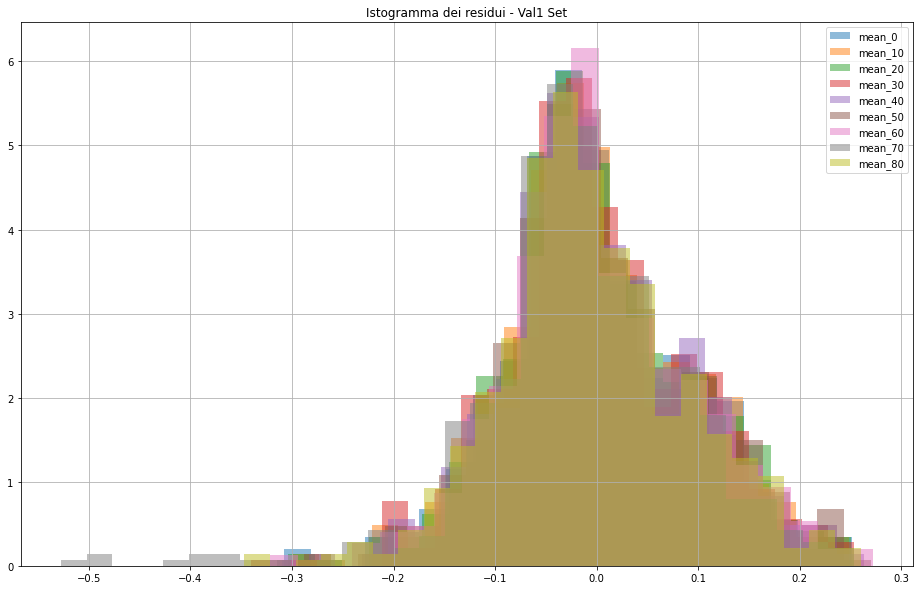

In [17]:
#res plot val1
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
for i in range(0, ans['res_val1'].shape[-1], 10):
    ax.hist([b[i] for b in ans['res_val1']], label=f'mean_{i}', bins='auto', density=True, alpha=0.5)
ax.set_title('Istogramma dei residui - Val1 Set')
ax.grid()
ax.legend()
plt.show()

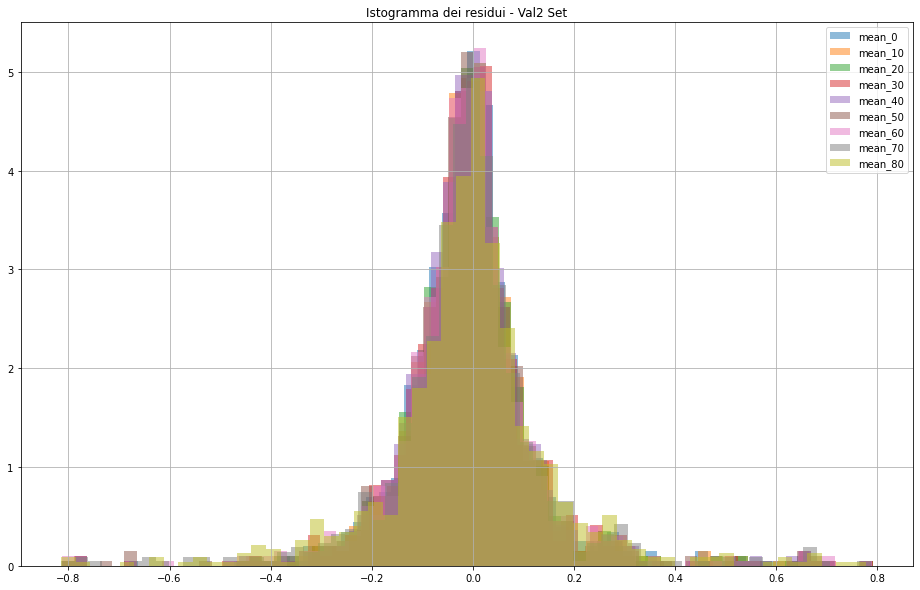

In [18]:
#res plot val2
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
for i in range(0, ans['res_val2'].shape[-1], 10):
    ax.hist([b[i] for b in ans['res_val2']], label=f'mean_{i}', bins='auto', density=True, alpha=0.5)
ax.set_title('Istogramma dei residui - Val2 Set')
ax.grid()
ax.legend()
plt.show()

#### Media e covarianza del residuo
Il valore del residuo per ogni previsione tende ad essere molto vicino a zero

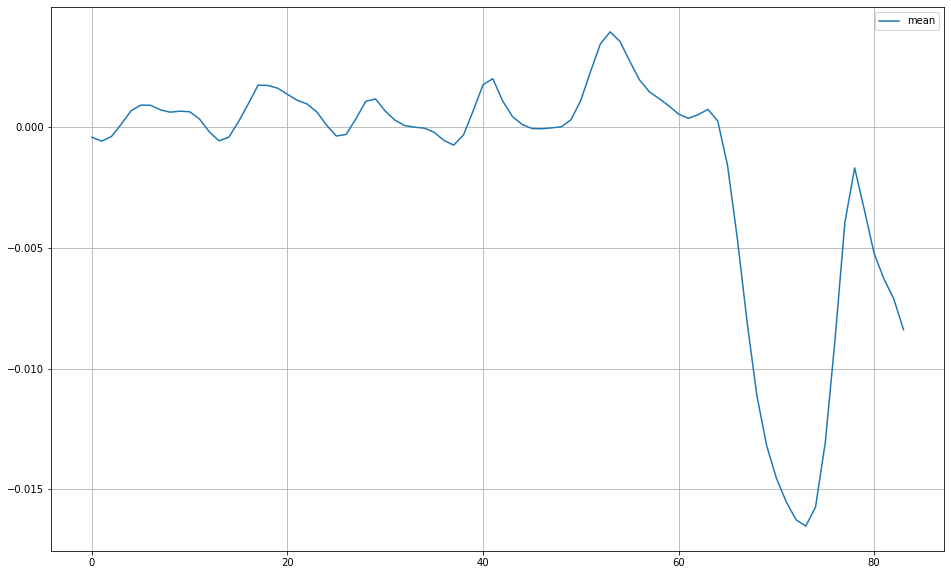

In [19]:
#media rispetto al tempo della previsione
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
ax.plot(ans['mean'], label=f'mean')
ax.grid()
ax.legend()
plt.show()

Possiamo osservare dalla matrice di covarianza una leggermente maggiore correlazione allineata per ogni giorno. <br>
Inoltre, possiamo anche osservare che il determinante della matrice di covarianza risulta essere molto vicino a zero (essendo tutti gli autovalori strettamente maggiori di zero e molto piccoli). Di conseguenza, essendo la matrice di covarianza quasi singolare, la distribuzione normale multivariata risulta essere degenere.

rank: 84/84
det: 0.0
min(eigvals): 4.617218706044036e-09


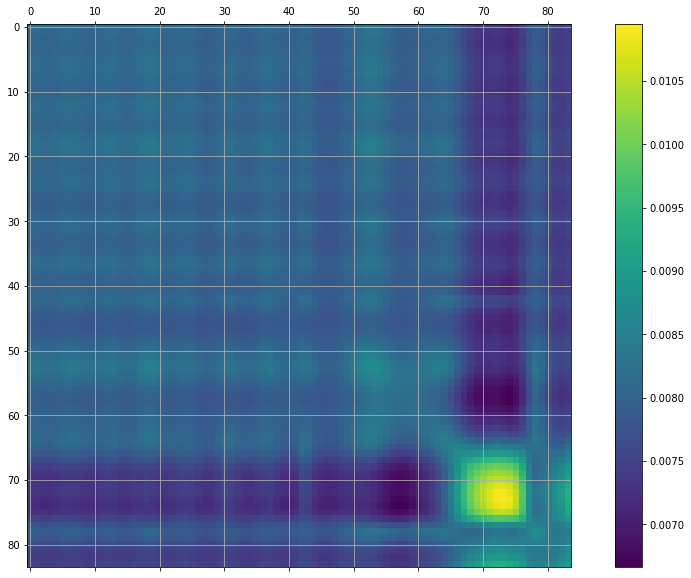

In [20]:
#matrice di covarianza

print(f'rank: {np.linalg.matrix_rank(ans["cov"])}/{len(ans["cov"])}')
print(f'det: {np.linalg.det(ans["cov"])}')
print(f'min(eigvals): {np.min(np.linalg.eigvals(ans["cov"]))}')

fig, ax = plt.subplots(figsize=FIG_SIZE)
cax = ax.matshow(ans['cov'])
ax.grid()
cbar = fig.colorbar(cax)
plt.show()

#### Confronta tra giorni normali e giorni anomali
La cella sottostante mostra che i residui relativi ai giorni anomali e normali appartengo a due distribuzioni diverse. <br>
Nei grafici sottostanti possiamo osservare come le distribuzioni dei residui siano diverse tra quelle dei giorni normali e quelle dei giorni anomali.

In [21]:
## Kolmogorov-Smirnov statistic on 2 samples
print('test (L2):  ', scipy.stats.ks_2samp(np.linalg.norm(ans['res_test'][ans['holidays_test'] == 0], axis=1, ord=2), 
                                         np.linalg.norm(ans['res_test'][ans['holidays_test'] == 1], axis=1, ord=2)))
print('test (prob):', scipy.stats.ks_2samp(scipy.stats.multivariate_normal.pdf(ans['res_test'][ans['holidays_test'] == 0], mean=ans['mean'], cov=ans['cov'], allow_singular=True),
                                           scipy.stats.multivariate_normal.pdf(ans['res_test'][ans['holidays_test'] == 1], mean=ans['mean'], cov=ans['cov'], allow_singular=True))) 
print('val2 (L2):  ', scipy.stats.ks_2samp(np.linalg.norm(ans['res_val2'][ans['holidays_val2'] == 0], axis=1, ord=2), 
                                    np.linalg.norm(ans['res_val2'][ans['holidays_val2'] == 1], axis=1, ord=2)))
print('val2 (prob):', scipy.stats.ks_2samp(scipy.stats.multivariate_normal.pdf(ans['res_val2'][ans['holidays_val2'] == 0], mean=ans['mean'], cov=ans['cov'], allow_singular=True),
                                           scipy.stats.multivariate_normal.pdf(ans['res_val2'][ans['holidays_val2'] == 1], mean=ans['mean'], cov=ans['cov'], allow_singular=True)))

test (L2):   Ks_2sampResult(statistic=0.1152797121634169, pvalue=0.004313609829323717)
test (prob): Ks_2sampResult(statistic=0.2507544103992572, pvalue=4.655165142253281e-13)
val2 (L2):   Ks_2sampResult(statistic=0.10733908948194662, pvalue=0.08589702433608692)
val2 (prob): Ks_2sampResult(statistic=0.21991104133961276, pvalue=3.9924844384975344e-06)


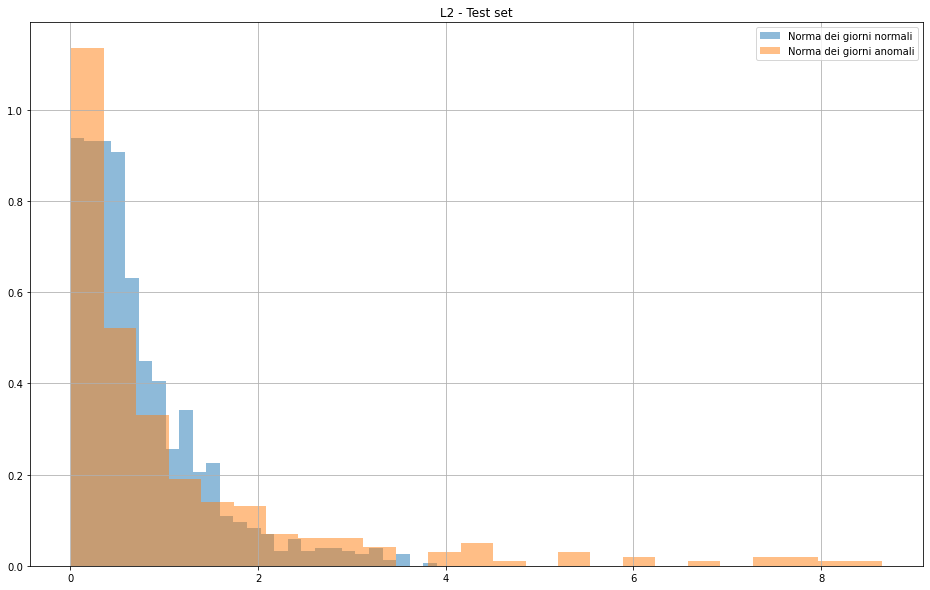

In [22]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = np.linalg.norm(ans['res_test'][ans['holidays_test'] == 0], axis=1, ord=2) 
prob_holidays = np.linalg.norm(ans['res_test'][ans['holidays_test'] == 1], axis=1, ord=2)

ax.hist(prob_normaldays, label='Norma dei giorni normali', bins='auto', density=True, alpha=0.5)
ax.hist(prob_holidays, label='Norma dei giorni anomali', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
ax.set_title('L2 - Test set')
plt.show()

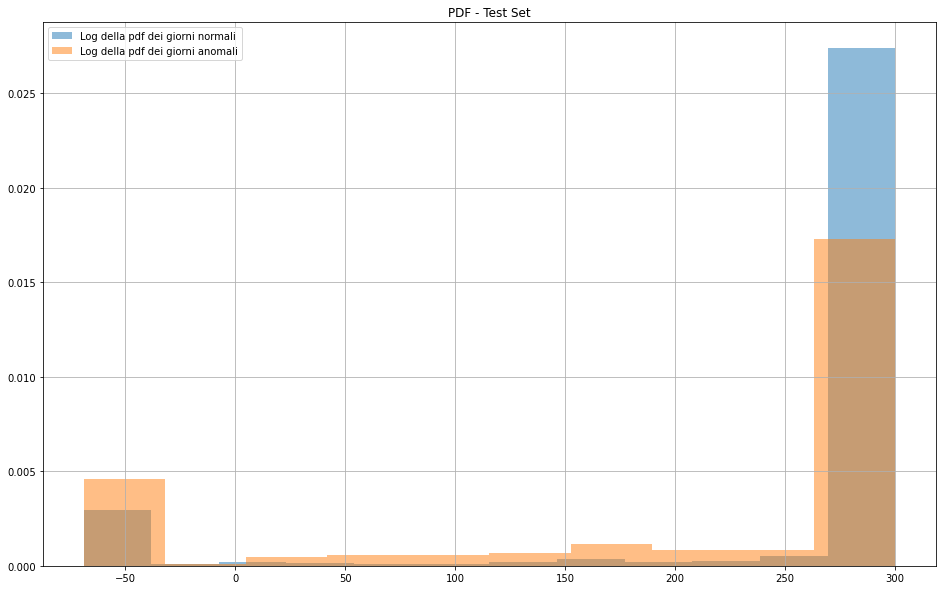

In [23]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = scipy.stats.multivariate_normal.pdf(ans['res_test'][ans['holidays_test'] == 0], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob_holidays = scipy.stats.multivariate_normal.pdf(ans['res_test'][ans['holidays_test'] == 1], mean=ans['mean'], cov=ans['cov'], allow_singular=True)

ax.hist(np.clip(np.log(prob_normaldays+1e-30), -100, 300), label='Log della pdf dei giorni normali', bins='auto', density=True, alpha=0.5)
ax.hist(np.clip(np.log(prob_holidays+1e-30), -100, 300), label='Log della pdf dei giorni anomali', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
ax.set_title('PDF - Test Set')
plt.show()

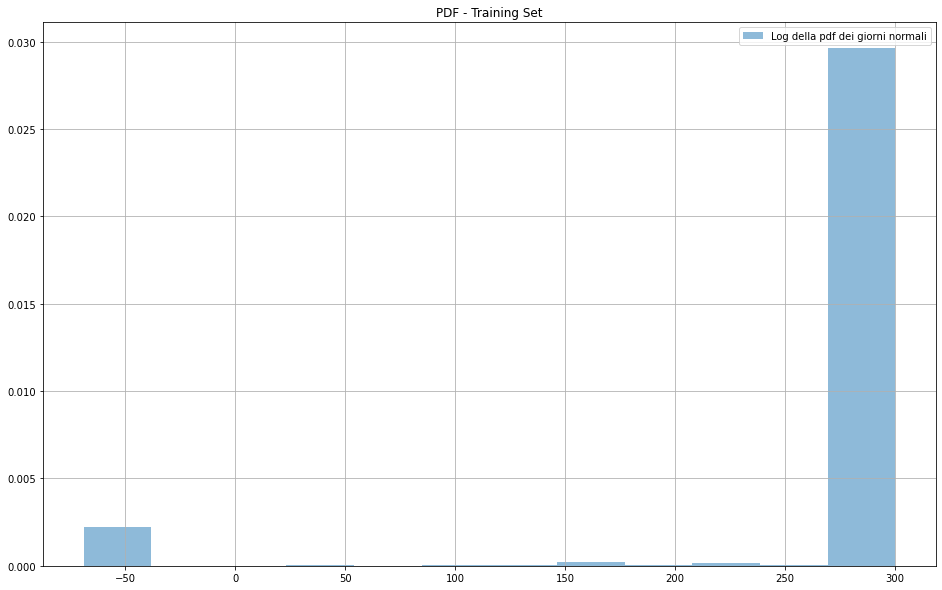

In [24]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = scipy.stats.multivariate_normal.pdf(ans['res_train'], mean=ans['mean'], cov=ans['cov'], allow_singular=True)

ax.hist(np.clip(np.log(prob_normaldays+1e-30), -100, 300), label='Log della pdf dei giorni normali', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
ax.set_title('PDF - Training Set')
plt.show()

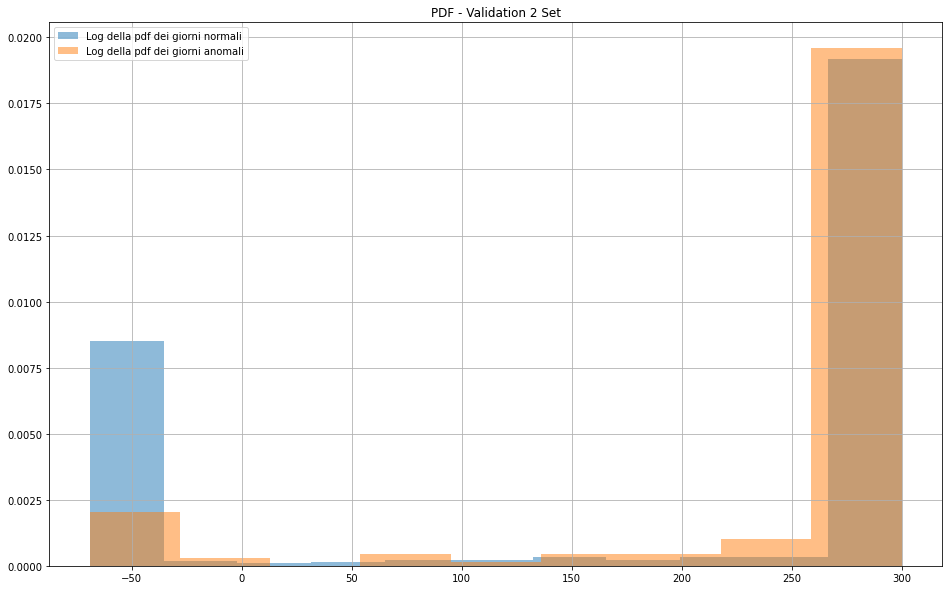

In [25]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = scipy.stats.multivariate_normal.pdf(ans['res_val2'][ans['holidays_val2'] == 0], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob_holidays = scipy.stats.multivariate_normal.pdf(ans['res_val2'][ans['holidays_val2'] == 1], mean=ans['mean'], cov=ans['cov'], allow_singular=True)

ax.hist(np.clip(np.log(prob_normaldays+1e-30), -100, 300), label='Log della pdf dei giorni normali', bins='auto', density=True, alpha=0.5)
ax.hist(np.clip(np.log(prob_holidays+1e-30), -100, 300), label='Log della pdf dei giorni anomali', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
ax.set_title('PDF - Validation 2 Set')
plt.show()

In [26]:
best_idx = np.argmin(abs(ans['mean']))
best_idx, np.argsort(abs(ans['mean']))

(33,
 array([33, 47, 34, 48, 45, 46, 32, 24, 44,  3, 12, 35, 15, 64, 26, 31, 38,
        49, 11, 25, 27,  2, 61, 14,  0, 43, 62, 36, 60, 13,  1,  8, 23, 10,
         9, 30,  4, 39, 37,  7, 63, 59,  6,  5, 22, 16, 28, 42, 21, 50, 29,
        58, 20, 57, 65, 19, 78, 18, 17, 40, 56, 41, 51, 55, 79, 52, 54, 77,
        53, 66, 80, 81, 82, 67, 83, 76, 68, 75, 69, 70, 71, 74, 72, 73],
       dtype=int64))

Le tre celle sottostanti mostrano i valori previsti e quelli reali assieme alle metriche usate per separare le distribuzioni.<br>
In particolare, possiamo osservare come il modello preveda correttamente i giorni normali, mentre mostra risultati molto peggiori per i giorni anomali. Questa differenza traspare anche attraverso le metriche utilizzate.<br>
<b>Nota:</b> Il modello realizza diverse previsioni, quella mostrata nel grafico è quella con minore valore assoluto della media.

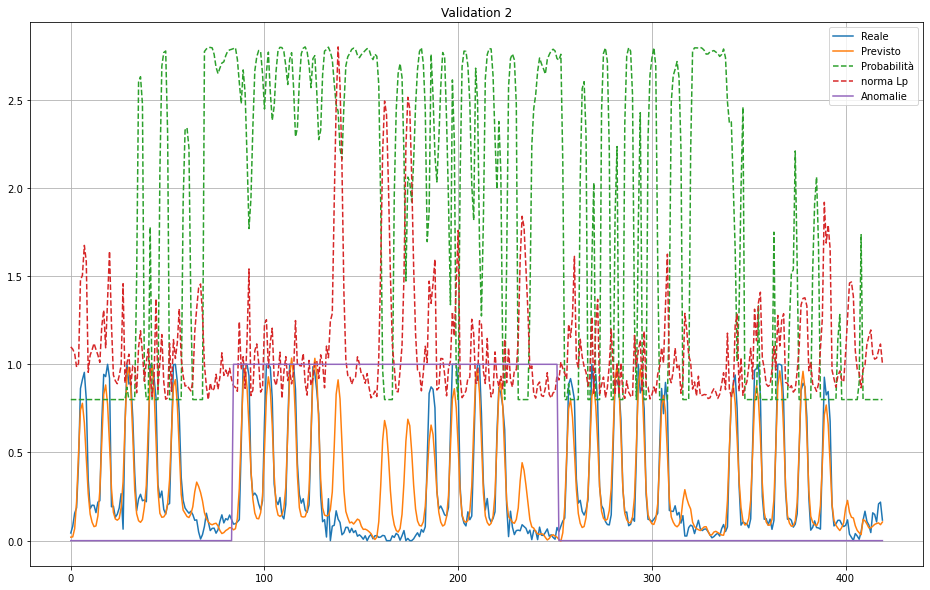

In [27]:
## val2 data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_val2'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_val2'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_val2_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_val2'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)
prob_test = prob.copy()

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_val2'][lower:upper], axis=1)
norm_test = prob.copy()
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.plot(ans['holidays_val2'][lower:upper], label='Anomalie', alpha=1.0)

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Validation 2')
plt.show()

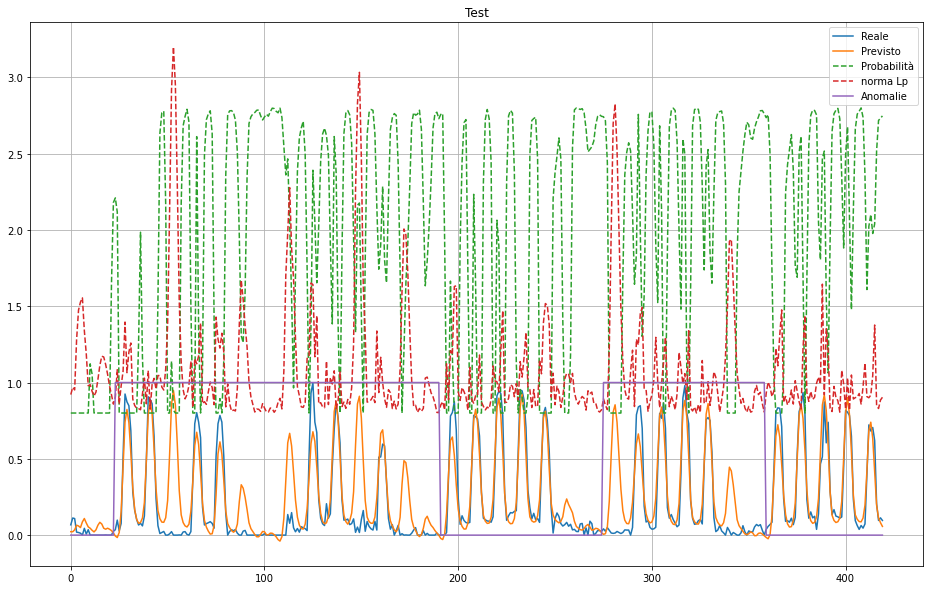

In [28]:
## test data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_test'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_test'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_test_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_test'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_test'][lower:upper], axis=1)
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.plot(ans['holidays_test'][lower:upper], label='Anomalie', alpha=1.0)

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Test')
plt.show()

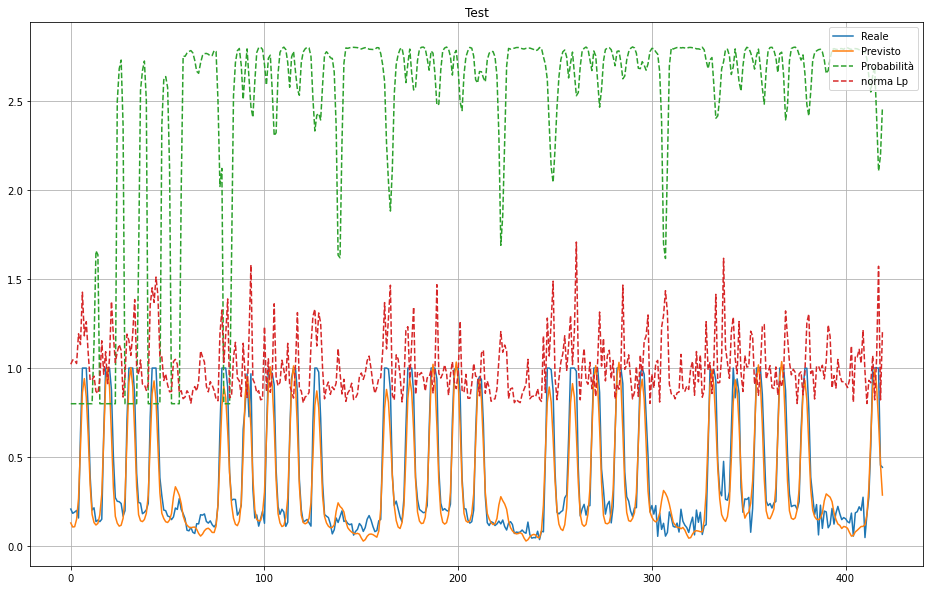

In [29]:
## train data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_train'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_train'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_train_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_train'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_train'][lower:upper], axis=1)
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Test')
plt.show()

Le due celle sottostanti mostrano le due metriche utilizzate:
* Probabilità: calcola la pdf gaussiana (con media e covarianza da val1) del residuo
* L2: calcola la norma L2 del residuo

Possiamo osservare come il secondo metodo risulti essere il migliore nella metrica considerata $F_{0.1}$

threshold: 3.865101789002091e+146 (309/805) - f0.1: 0.3666632092106628 - f0.1(validation): 0.24162679425837325
{'auc': 0.7300550747442958, 'accuracy': 0.6581632653061225, 'recall': 0.8536585365853658, 'precision': 0.3645833333333333}

              precision    recall  f1-score   support

           0       0.94      0.61      0.74       155
           1       0.36      0.85      0.51        41

    accuracy                           0.66       196
   macro avg       0.65      0.73      0.62       196
weighted avg       0.82      0.66      0.69       196



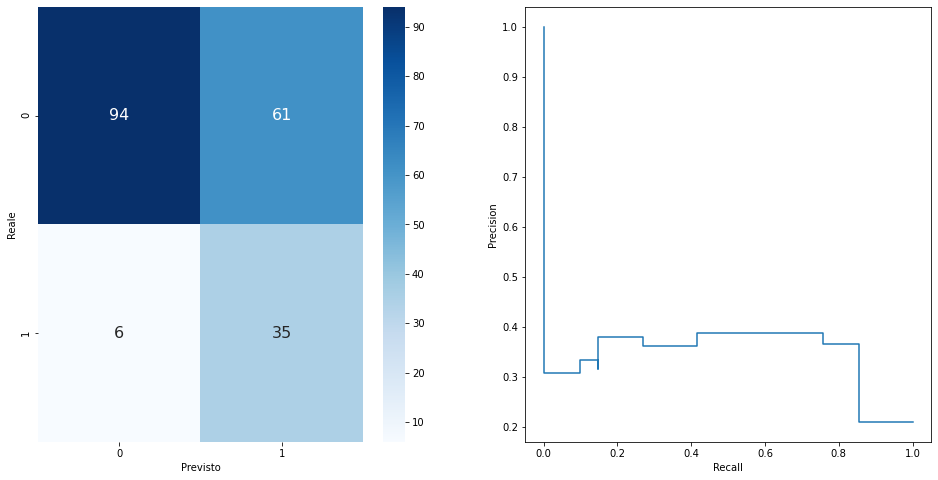

In [30]:
# Probabilità
print_results(ans, True, distance_metric='prob')

threshold: 4.270500616285789 (788/805) - f0.1: 0.9541160593792173 - f0.1(validation): 0.6975138121546961
{'auc': 0.5853658536585366, 'accuracy': 0.826530612244898, 'recall': 0.17073170731707318, 'precision': 1.0}

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       155
           1       1.00      0.17      0.29        41

    accuracy                           0.83       196
   macro avg       0.91      0.59      0.60       196
weighted avg       0.86      0.83      0.77       196



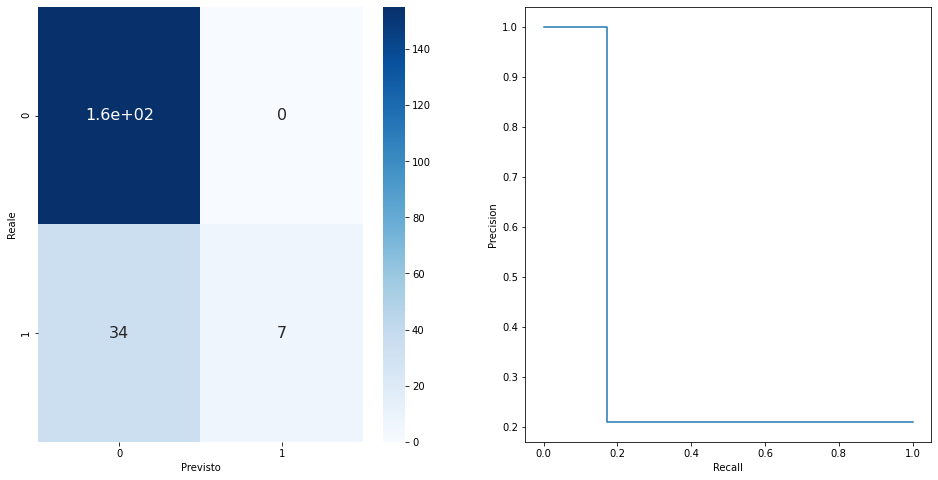

In [31]:
# Norma L2
print_results(ans, True, distance_metric=2)

### Second Floor
Questo dataset rispetto a quello dei Paesi Bassi possiede molti più trend (sia settimanali che stagionali), di conseguenza risulta più complicato ed è quindi molto più difficile ottenere previsioni consistenti (in particolare nei weekend e durante la notte). Il modello usato per questo dataset ha molti più parametri rispetto al modello usato per il dataset dei Paesi Bassi, ma anche tecniche di regolarizzazione più potenti (dropout rate maggiore).

In [32]:
df = pd.read_pickle('train1.pkl')
df

,AvgP1,AvgT,AvgH,AvgP2,AvgP3,DateTime,holidays,dayofweek
DateTime,,,,,,,,
2017-02-08 00:00:00,35.0,4.30,94.199997,34.0,87.0,2017-02-08 00:00:00,0,2
2017-02-08 00:15:00,0.0,4.80,94.550003,0.0,0.0,2017-02-08 00:15:00,0,2
2017-02-08 00:30:00,0.0,5.40,94.800003,51.0,0.0,2017-02-08 00:30:00,0,2
2017-02-08 00:45:00,0.0,5.40,94.449997,0.0,83.0,2017-02-08 00:45:00,0,2
2017-02-08 01:00:00,53.0,5.50,94.199997,0.0,0.0,2017-02-08 01:00:00,0,2
...,...,...,...,...,...,...,...,...
2019-04-09 22:45:00,41.0,10.95,83.250000,41.0,65.0,2019-04-09 22:45:00,0,1
2019-04-09 23:00:00,42.0,10.80,84.599998,42.0,68.0,2019-04-09 23:00:00,0,1
2019-04-09 23:15:00,43.0,10.65,86.050003,43.0,72.0,2019-04-09 23:15:00,0,1


In [33]:
params = {'dense_activation': 'swish', 
          'dropout_rate': 0.45, 
          'ensemble': 5, 
          'hidden_unit': 100, 
          'inp_dropout': 0.0, 
          'inp_noise': 0.2, 
          'loss': 'mse', 
          'recurrent': 'lstm', 
          'units': [80, 30, 50]
}

In [34]:
gc.collect()

269698

In [35]:
if HYPERTUNE:
    df_x, df_y = df['AvgP1'].to_numpy(), df['holidays'].to_numpy()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=40)
else:
    best = None
gc.collect()
best

In [36]:
ans = run(df['AvgP1'].to_numpy(), df['holidays'].to_numpy(), params=params)

61824 14112
x_train: (2363, 168, 1)
x_val1: (920, 168, 1)
x_val2: (2482, 168, 1)
x_test: (3547, 168, 1)
Epoch 1/1000
5/5 [==============================] - 8s 2s/step - loss: 0.2022 - mse: 0.2022 - mape: 28102104.0000 - mae: 0.3448 - val_loss: 0.1523 - val_mse: 0.1523 - val_mape: 9588789.0000 - val_mae: 0.2992
Epoch 2/1000
5/5 [==============================] - 2s 477ms/step - loss: 0.1080 - mse: 0.1080 - mape: 26380082.0000 - mae: 0.2666 - val_loss: 0.1042 - val_mse: 0.1042 - val_mape: 20330306.0000 - val_mae: 0.2705
Epoch 3/1000
5/5 [==============================] - 2s 471ms/step - loss: 0.0959 - mse: 0.0959 - mape: 29836850.0000 - mae: 0.2606 - val_loss: 0.1116 - val_mse: 0.1116 - val_mape: 16743634.0000 - val_mae: 0.2709
Epoch 4/1000
5/5 [==============================] - 2s 476ms/step - loss: 0.0950 - mse: 0.0950 - mape: 30699210.0000 - mae: 0.2611 - val_loss: 0.1038 - val_mse: 0.1038 - val_mape: 20149306.0000 - val_mae: 0.2694
Epoch 5/1000
5/5 [==============================] - 

5/5 [==============================] - 2s 473ms/step - loss: 0.0211 - mse: 0.0211 - mape: 11109170.0000 - mae: 0.1013 - val_loss: 0.0203 - val_mse: 0.0203 - val_mape: 4486674.0000 - val_mae: 0.0921
Epoch 74/1000
5/5 [==============================] - 2s 473ms/step - loss: 0.0212 - mse: 0.0212 - mape: 11227907.0000 - mae: 0.1015 - val_loss: 0.0205 - val_mse: 0.0205 - val_mape: 4519392.5000 - val_mae: 0.0924
Epoch 75/1000
5/5 [==============================] - ETA: 0s - loss: 0.0211 - mse: 0.0211 - mape: 11119523.0000 - mae: 0.1012
Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
5/5 [==============================] - 2s 474ms/step - loss: 0.0211 - mse: 0.0211 - mape: 11119523.0000 - mae: 0.1012 - val_loss: 0.0202 - val_mse: 0.0202 - val_mape: 4525589.5000 - val_mae: 0.0919
Epoch 76/1000
5/5 [==============================] - 2s 473ms/step - loss: 0.0211 - mse: 0.0211 - mape: 11162330.0000 - mae: 0.1012 - val_loss: 0.0202 - val_mse: 0.0202 - val_mape: 4497

In [37]:
for metric, val_metric in [('mse', 'val_mse'), ('mse', 'val_mse'), ('mape', 'val_mape')]:
    print(f"{metric.rjust(8)}: {str(round(ans[metric], 3)).rjust(8)} - {str(round(ans[val_metric], 3)).rjust(8)}")

     mse:    0.021 -     0.02
     mse:    0.021 -     0.02
    mape: 11086519.0 - 3915087.75


#### Media e covarianza del residuo

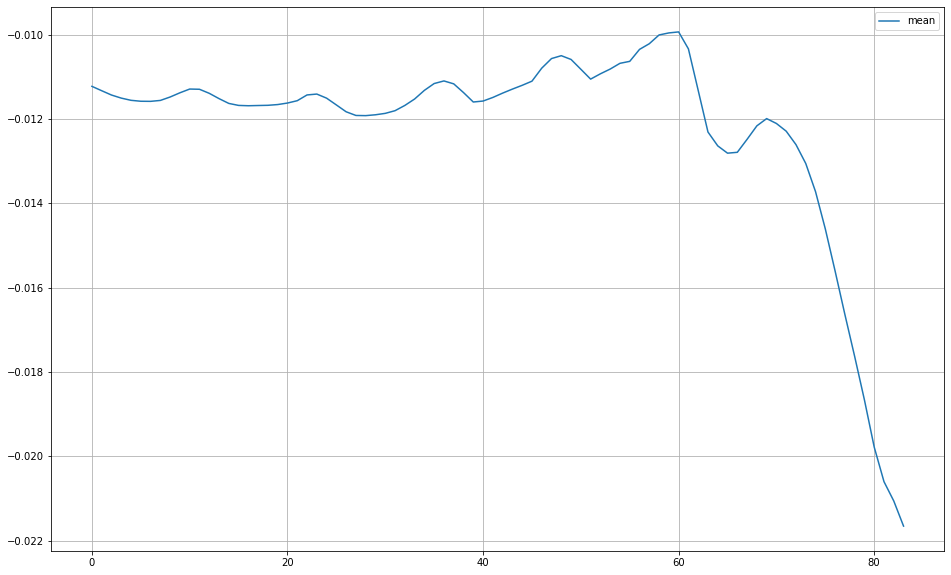

In [38]:
#mean graph
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
ax.plot(ans['mean'], label=f'mean')
ax.grid()
ax.legend()
plt.show()

rank: 84/84 det: 0.0 min(eigvals): 7.022844653626241e-10


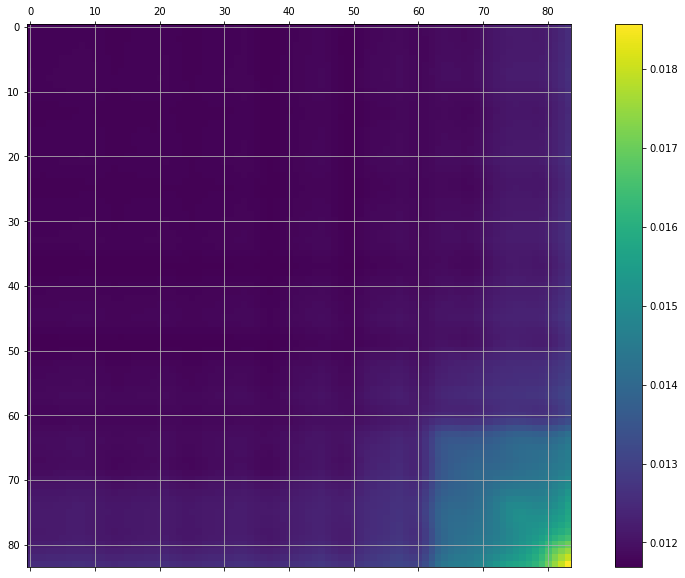

In [39]:
#convariance matrix

print(f'rank: {np.linalg.matrix_rank(ans["cov"])}/{len(ans["cov"])} det: {np.linalg.det(ans["cov"])} min(eigvals): {np.min(np.linalg.eigvals(ans["cov"]))}')

fig, ax = plt.subplots(figsize=FIG_SIZE)
cax = ax.matshow(ans['cov'])
ax.grid()
cbar = fig.colorbar(cax)
plt.show()

#### Confronta tra giorni normali e giorni anomali
Nel grafico sottostante possiamo osservare come i giorni anomali tendano ad avere una norma maggiore rispetto ai giorni normali.

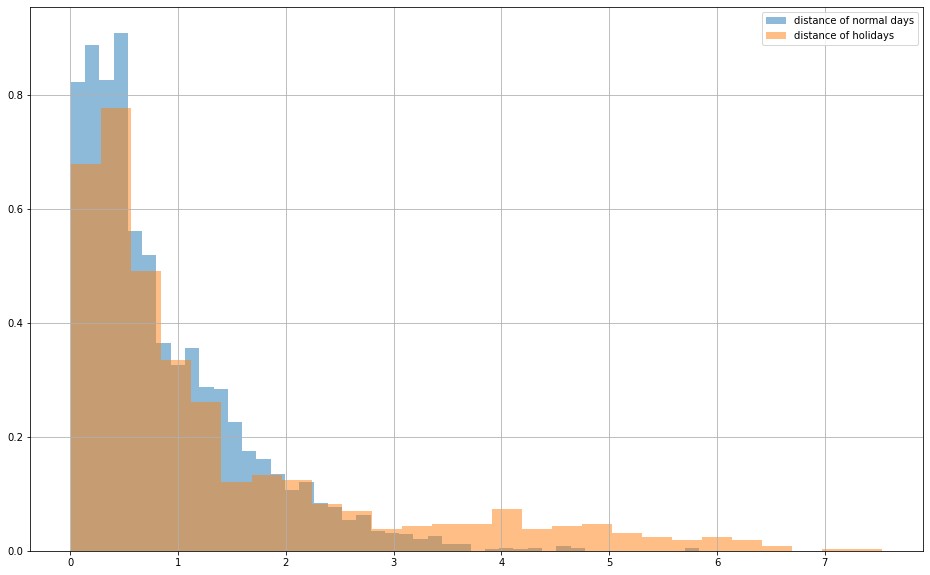

In [40]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = np.linalg.norm(ans['res_test'][ans['holidays_test'] == 0], axis=1, ord=2)
prob_holidays = np.linalg.norm(ans['res_test'][ans['holidays_test'] == 1], axis=1, ord=2)

ax.hist(prob_normaldays, label='distance of normal days', bins='auto', density=True, alpha=0.5)
ax.hist(prob_holidays, label='distance of holidays', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
plt.show()

In [41]:
best_idx = np.argmin(abs(ans['mean']))
best_idx, np.argsort(abs(ans['mean']))

(60,
 array([60, 59, 58, 57, 61, 56, 48, 47, 49, 55, 54, 46, 53, 50, 52, 51, 36,
        45, 35, 37, 44,  0, 10, 43, 11, 34, 62,  1, 38,  9, 42, 12, 23, 22,
         2,  8, 41,  3, 24, 13, 33,  4,  7, 21, 40,  5,  6, 39, 20, 14, 19,
        25, 18, 15, 32, 17, 16, 31, 26, 30, 29, 27, 28, 69, 70, 68, 71, 63,
        67, 72, 64, 66, 65, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83],
       dtype=int64))

Possiamo notare che il modello non riesca a prevedere correttamente i giorni anomali, mentre riesca a prevedere meglio i giorni normali.
Tuttavia, questo dataset è più complesso rispetto al dataset dei Paesi Bassi, quindi il modello tende ad essere molto meno preciso, in particolare nel weekend e durante la notte.

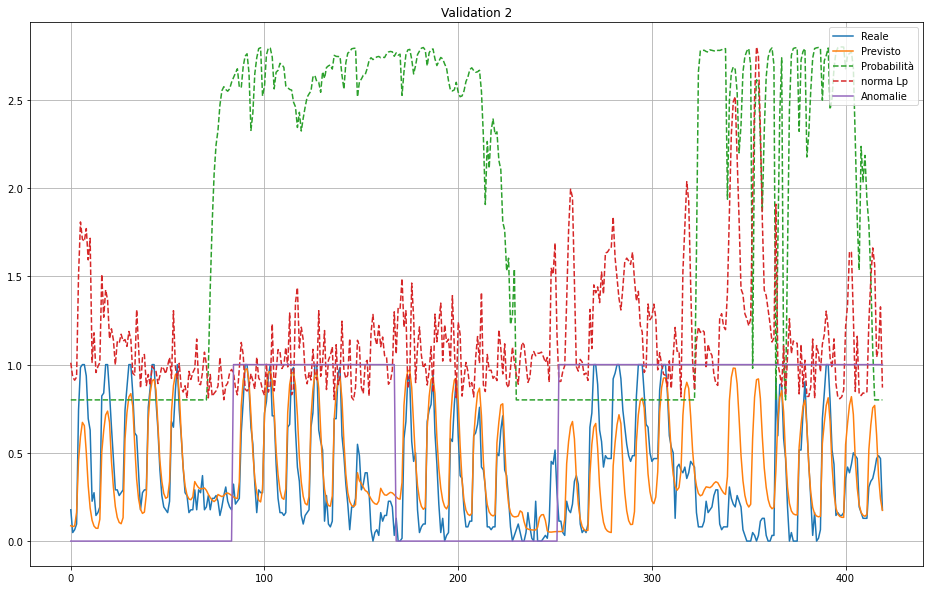

In [42]:
## val2 data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_val2'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_val2'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_val2_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_val2'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)
prob_test = prob.copy()

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_val2'][lower:upper], axis=1)
norm_test = prob.copy()
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.plot(ans['holidays_val2'][lower:upper], label='Anomalie', alpha=1.0)

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Validation 2')
plt.show()

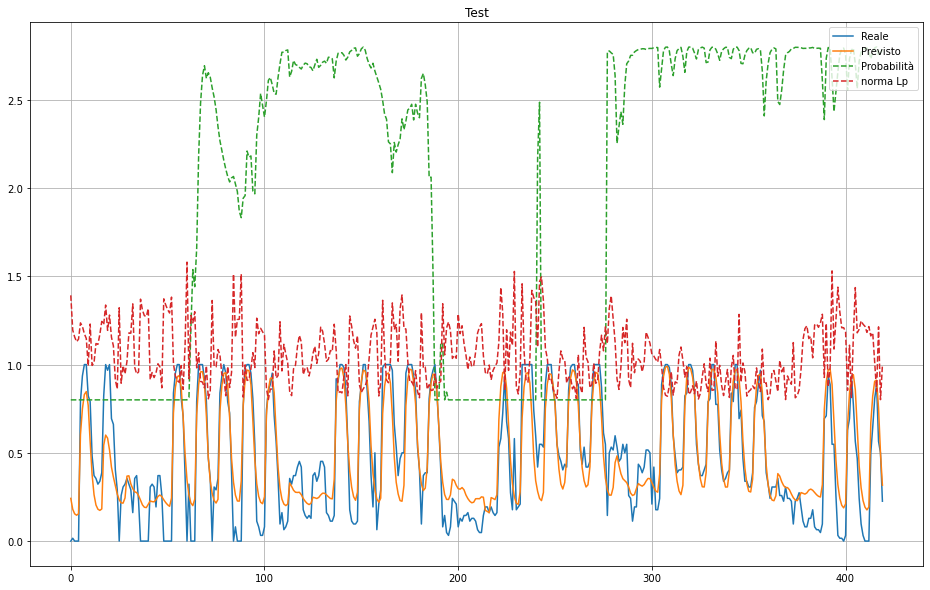

In [43]:
## train data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_train'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_train'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_train_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_train'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_train'][lower:upper], axis=1)
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Test')
plt.show()

threshold: 0.0 (0/2488) - f0.1: 0.4055759522716843 - f0.1(validation): 0.34820234996130306
{'auc': 0.6285467406157061, 'accuracy': 0.6758349705304518, 'recall': 0.5303030303030303, 'precision': 0.4046242774566474}

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       377
           1       0.40      0.53      0.46       132

    accuracy                           0.68       509
   macro avg       0.61      0.63      0.61       509
weighted avg       0.71      0.68      0.69       509



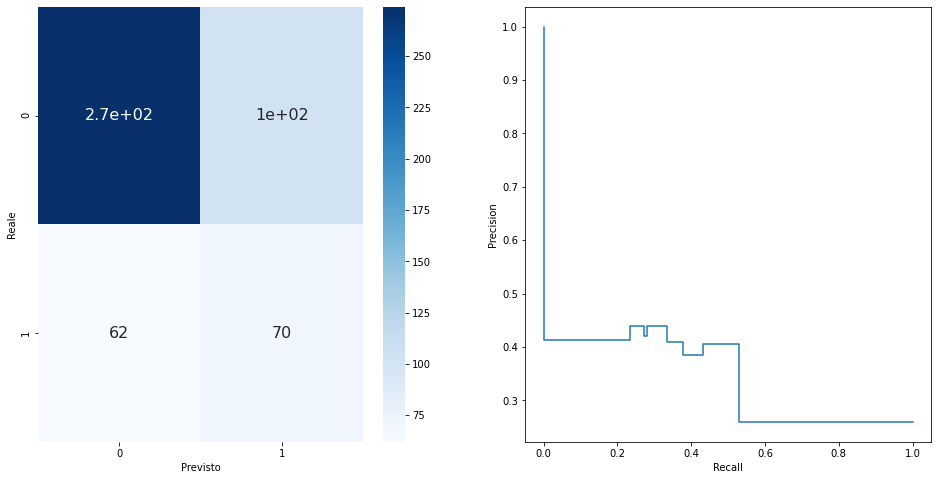

In [44]:
# Probabilità
print_results(ans, True, distance_metric='prob')

threshold: 4.52316489447726 (2419/2488) - f0.1: 0.8061941251596424 - f0.1(validation): 0.9145789314820404
{'auc': 0.5880656699622216, 'accuracy': 0.7799607072691552, 'recall': 0.1893939393939394, 'precision': 0.8333333333333334}

              precision    recall  f1-score   support

           0       0.78      0.99      0.87       377
           1       0.83      0.19      0.31       132

    accuracy                           0.78       509
   macro avg       0.80      0.59      0.59       509
weighted avg       0.79      0.78      0.72       509



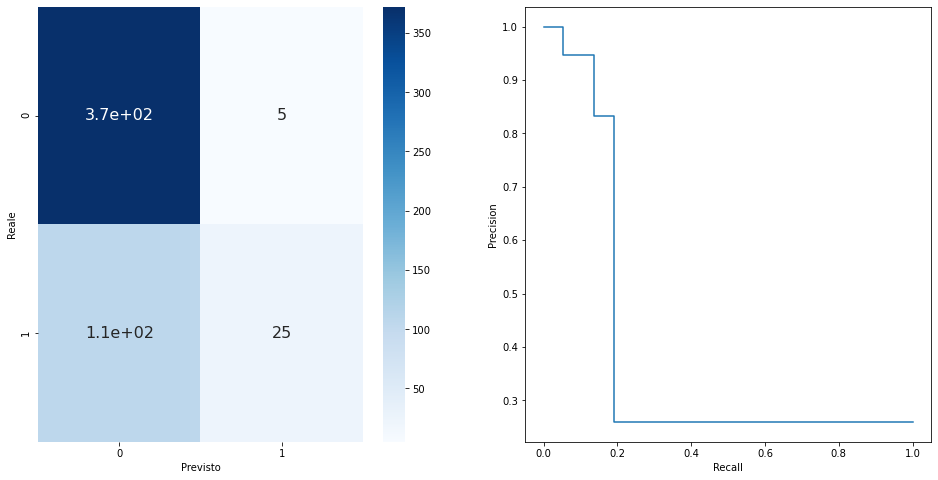

In [45]:
#Norma L2
print_results(ans, True, distance_metric=2)

### Third Floor
Il terzo dataset risulta essere molto più caotico e difficile da prevedere. Infatti, possiamo osservare come il modello non riesca ad apprendere completamente lo schema. Ne conseguono pessimi risultati in tutte le metriche considerate. Al contrario dei dataset precedenti la likelihood mostra risultati leggermente migliori, probabilmente questo fenomeno avviene perché la likelihood riesce a pesare meglio gli errori.

In [46]:
df = pd.read_pickle('train1.pkl')

In [47]:
params = {'dense_activation': 'swish', 
          'dropout_rate': 0.1, 
          'ensemble': 4, 
          'hidden_unit': 128, 
          'inp_dropout': 0.0, 
          'inp_noise': 0.2, 
          'loss': 'mse', 
          'recurrent': 'lstm', 
          'units': [160]
}

In [48]:
if HYPERTUNE:
    df_x, df_y = df['AvgP3'].to_numpy(), df['holidays'].to_numpy()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=40)
else:
    best = None
tf.keras.backend.clear_session()
gc.collect()
best

In [49]:
ans = run(df['AvgP3'].to_numpy(), df['holidays'].to_numpy(), params=params)

61824 14112
x_train: (2363, 168, 1)
x_val1: (920, 168, 1)
x_val2: (2482, 168, 1)
x_test: (3547, 168, 1)
Epoch 1/1000
5/5 [==============================] - 3s 682ms/step - loss: 3.2259 - mse: 3.2259 - mape: 142001568.0000 - mae: 1.0088 - val_loss: 0.3018 - val_mse: 0.3018 - val_mape: 6042.7617 - val_mae: 0.5090
Epoch 2/1000
5/5 [==============================] - 2s 369ms/step - loss: 0.0864 - mse: 0.0864 - mape: 24957172.0000 - mae: 0.2313 - val_loss: 0.0837 - val_mse: 0.0837 - val_mape: 22158.2070 - val_mae: 0.2377
Epoch 3/1000
5/5 [==============================] - 2s 367ms/step - loss: 0.0570 - mse: 0.0570 - mape: 36605044.0000 - mae: 0.1962 - val_loss: 0.1134 - val_mse: 0.1134 - val_mape: 17054.0645 - val_mae: 0.2881
Epoch 4/1000
5/5 [==============================] - 2s 402ms/step - loss: 0.0504 - mse: 0.0504 - mape: 35912528.0000 - mae: 0.1846 - val_loss: 0.0420 - val_mse: 0.0420 - val_mape: 22730.7559 - val_mae: 0.1657
Epoch 5/1000
5/5 [==============================] - 2s 381ms

Epoch 37/1000
5/5 [==============================] - 2s 374ms/step - loss: 0.0239 - mse: 0.0239 - mape: 15763320.0000 - mae: 0.1194 - val_loss: 0.0247 - val_mse: 0.0247 - val_mape: 14118.3730 - val_mae: 0.1237
Epoch 38/1000
5/5 [==============================] - 2s 370ms/step - loss: 0.0238 - mse: 0.0238 - mape: 15689409.0000 - mae: 0.1191 - val_loss: 0.0251 - val_mse: 0.0251 - val_mape: 14023.0225 - val_mae: 0.1256
Epoch 39/1000
5/5 [==============================] - 2s 367ms/step - loss: 0.0237 - mse: 0.0237 - mape: 15972153.0000 - mae: 0.1190 - val_loss: 0.0244 - val_mse: 0.0244 - val_mape: 14627.2461 - val_mae: 0.1227
Epoch 40/1000
5/5 [==============================] - 2s 367ms/step - loss: 0.0237 - mse: 0.0237 - mape: 15658286.0000 - mae: 0.1187 - val_loss: 0.0246 - val_mse: 0.0246 - val_mape: 14265.2686 - val_mae: 0.1235
Epoch 41/1000
5/5 [==============================] - ETA: 0s - loss: 0.0237 - mse: 0.0237 - mape: 15482571.0000 - mae: 0.1188
Epoch 00041: ReduceLROnPlateau red

In [50]:
for metric in ['mse', 'val_mse', 'mae', 'val_mae', 'mape', 'val_mape']:
    print(f"{metric.rjust(8)}: {round(np.mean(ans[metric]), 3)} +- {round(np.std(ans[metric]), 3)}")

     mse: 0.023 +- 0.0
 val_mse: 0.024 +- 0.0
     mae: 0.118 +- 0.0
 val_mae: 0.123 +- 0.0
    mape: 15469721.0 +- 0.0
val_mape: 6042.762 +- 0.0


#### Media e covarianza del residuo
Sia nella matrice di covarianza che nel vettore delle medie possiamo notare che ha un pattern correlato ai giorni. Ipotizzo che sia dovuto principalmente alle difficoltà del modello nel prevedere l'esatta altezza del picco del giorno.

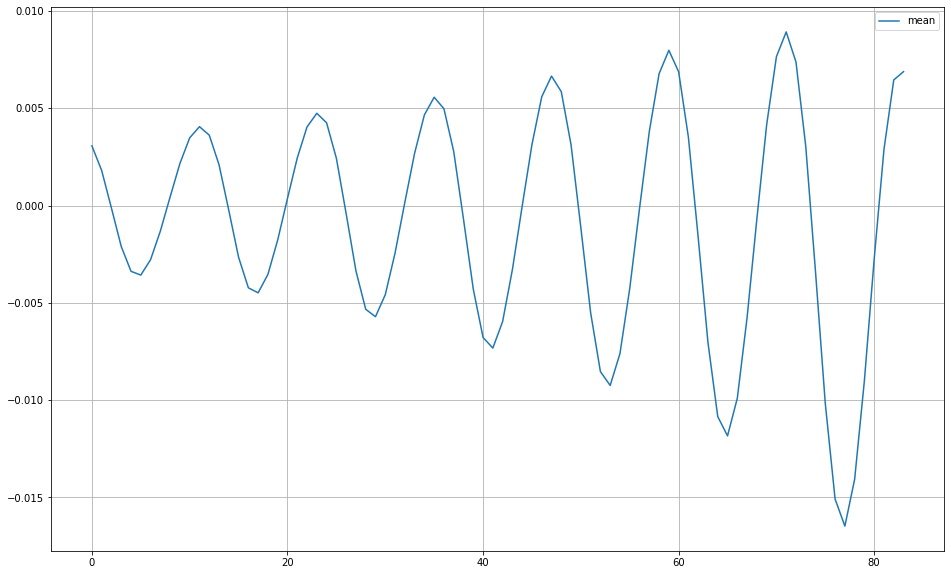

In [51]:
#mean graph
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
ax.plot(ans['mean'], label=f'mean')
ax.grid()
ax.legend()
plt.show()

rank: 84/84 det: 0.0 min(eigvals): 3.464618995837623e-08


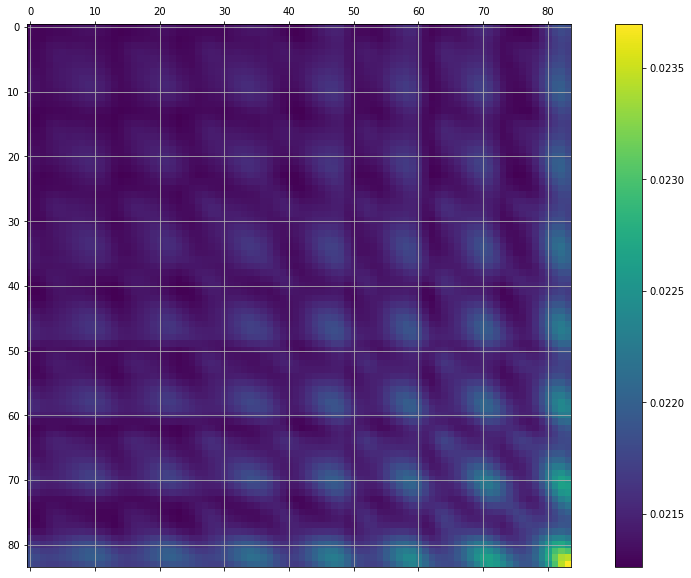

In [52]:
#convariance matrix

print(f'rank: {np.linalg.matrix_rank(ans["cov"])}/{len(ans["cov"])} det: {np.linalg.det(ans["cov"])} min(eigvals): {np.min(np.linalg.eigvals(ans["cov"]))}')

fig, ax = plt.subplots(figsize=FIG_SIZE)
cax = ax.matshow(ans['cov'])
ax.grid()
cbar = fig.colorbar(cax)
plt.show()

#### Confronta tra giorni normali e giorni anomali

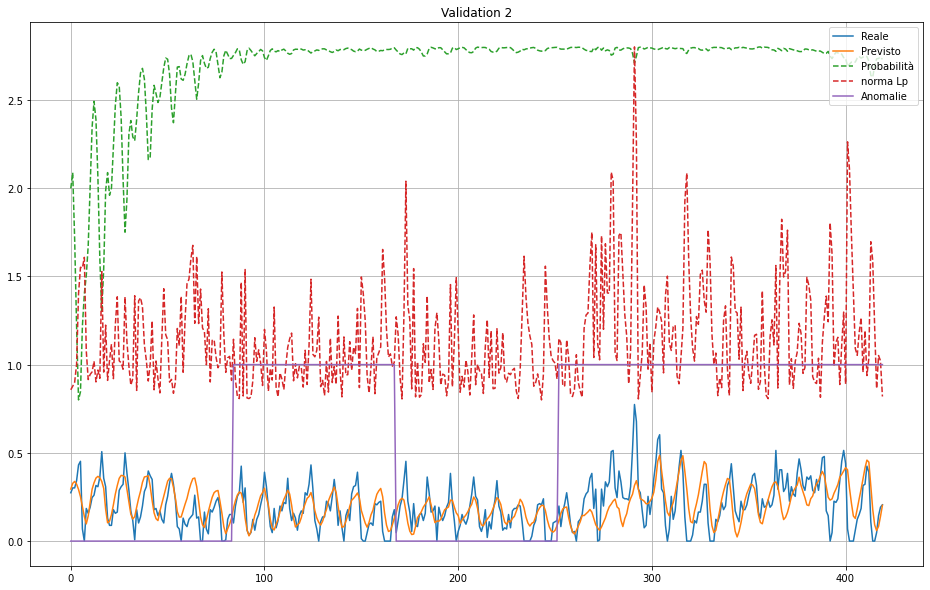

In [53]:
## val2 data
best_idx = 0
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_val2'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_val2'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_val2_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_val2'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)
prob_test = prob.copy()

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_val2'][lower:upper], axis=1)
norm_test = prob.copy()
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.plot(ans['holidays_val2'][lower:upper], label='Anomalie', alpha=1.0)

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Validation 2')
plt.show()

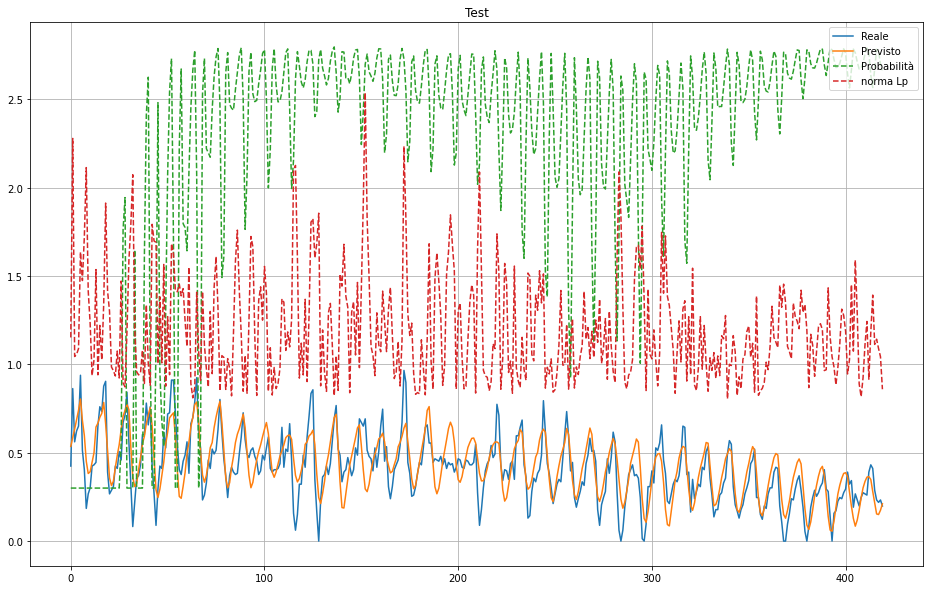

In [54]:
## train data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_train'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_train'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_train_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_train'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = np.clip(prob, -0.5, 4.0) + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_train'][lower:upper], axis=1)
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.grid()
ax.legend(loc='upper right')
ax.set_title('Test')
plt.show()

threshold: 2.592377372663479e+193 (2279/2488) - f0.1: 0.26124784448973193 - f0.1(validation): 0.3177957842563974
{'auc': 0.5, 'accuracy': 0.2593320235756385, 'recall': 1.0, 'precision': 0.2593320235756385}

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       377
           1       0.26      1.00      0.41       132

    accuracy                           0.26       509
   macro avg       0.13      0.50      0.21       509
weighted avg       0.07      0.26      0.11       509



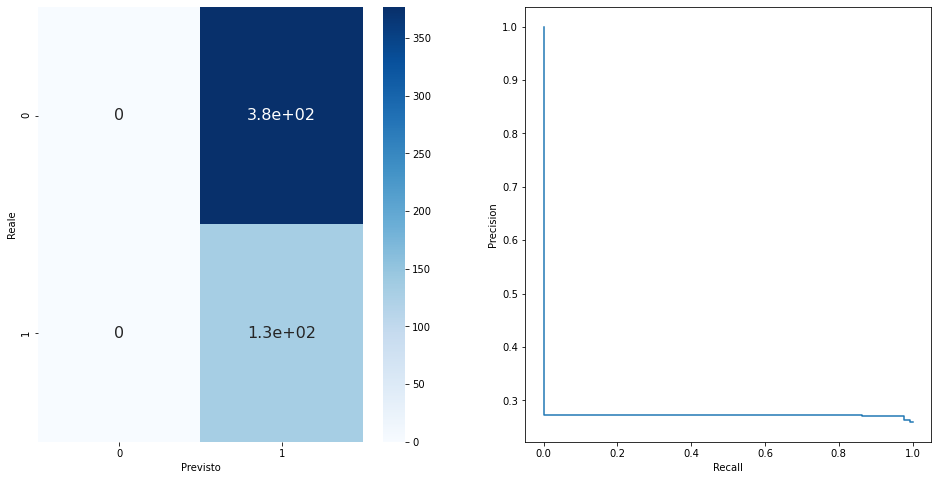

In [55]:
# Probabilità
print_results(ans, True, distance_metric='prob')

threshold: 3.7923713287166185 (2473/2488) - f0.1: 0.1653930131004367 - f0.1(validation): 0.45372866127583106
{'auc': 0.4927959971063419, 'accuracy': 0.7190569744597249, 'recall': 0.022727272727272728, 'precision': 0.17647058823529413}

              precision    recall  f1-score   support

           0       0.74      0.96      0.84       377
           1       0.18      0.02      0.04       132

    accuracy                           0.72       509
   macro avg       0.46      0.49      0.44       509
weighted avg       0.59      0.72      0.63       509



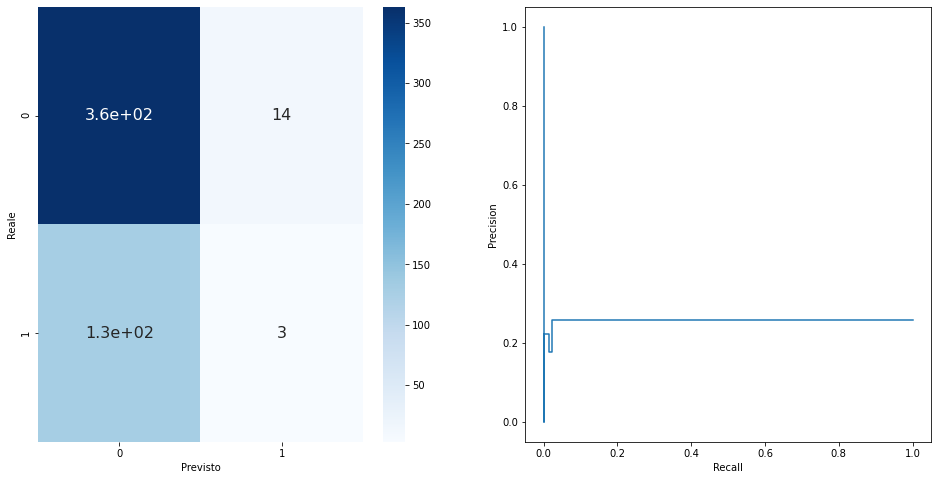

In [56]:
#Norma L2
print_results(ans, True, distance_metric=2)